# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Загрузим необходимые модули
import statistics

import matplotlib as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [2]:
# Настроим sklearn на работу с объектами pandas
set_config(transform_output="pandas")

In [3]:
# Загрузим данные и посмотрим первые несколько строк
data = pd.read_csv('autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# Посмотрим основную информацию о столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Первый взгляд на данные позволяет поставить три задачи:
1. Изменить формат заголовков;
2. Преобразовать данные с датами в соответствующий тип;
3. Избавиться от пропусков.


In [5]:
# Заменяем названия столбцов
def camel_to_snake(str, sep='_'):
    '''Получает строку и преобразовывает Camel Case в Snake Case'''
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register = snake_register + sep + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip(sep)

data.columns = [camel_to_snake(i) for i in data.columns]


In [6]:
# Заменяем тип столбцов с датами
for i in ['date_crawled', 'date_created', 'last_seen']:
    data[i] = pd.to_datetime(data[i], format='%Y-%m-%d %H:%M:%S')
data.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

In [7]:
def miss_report(data):
    '''Показывает информацию о пропусках в DataFrame'''
    print('Количество пропусков всего', data.isna().sum().sum())
    print('Доля пропусков в столбцах')
    display(data.isna().mean().sort_values(ascending=False))
    print('Доля строк с различным количеством пропусков')
    display(data.isna().sum(axis=1).value_counts(sort=True, ascending=False, normalize=True) * 100)
miss_report(data)

Количество пропусков всего 181077
Доля пропусков в столбцах


repaired              0.200791
vehicle_type          0.105794
fuel_type             0.092827
gearbox               0.055967
model                 0.055606
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Доля строк с различным количеством пропусков


0    69.366677
1    18.150007
2     7.395963
3     2.824175
4     1.631915
5     0.631263
Name: proportion, dtype: float64

Итак, мы видим, что пропусков не так мало. Они сосредоточены в пяти столбцах. Объем пропусков до 20 %. Если смотреть по строкам, есть примерно 5 % объектов, для которых неизвестно 3 признака и более. Попробуем заполнить пропуски, а потом вернемся к этому отчету, чтобы решить, какие значения имеет смысл удалить.
Предполагаю, что восстановить тип автомобиля будет легко, если поискать аналогичные по бренду и модели транспортные средства. Аналогично и с моделью, которая должна достоверно устанавливаться по бренду и типу. Как можно увидеть в таблице выше, строк, где нет и модели, и типа транспорта относительно мало.
Тип топлива попробуем восстановить по принципу наиболее популярного для сочетания модели и бренда. Аналогично и для коробки передач.
Решения относительно наличия ремонта пока нет. Вернемся к этому вопросу чуть позже.


In [8]:
def fill_by_patern(data, target, features):
    '''Функция предназначена для заполнения пропусков в данных.
    Принимает DataFrame, целевой и опорные признаки. Ищет пропуски в целевом признаке и заполняет его 
    наиболее распространенным значением для сочетания опорных признаков.
    Возвращает DataFrame с заполненными пропусками'''
    table = data.pivot_table(index=features, values=target, aggfunc=statistics.mode, dropna=False)
    a = [data[i].notnull() for i in features]
    notnull_features = np.prod(a, axis=0)
    for row in data.loc[(data[target].isna() * notnull_features).astype('bool')].iterrows():
        current_index = [row[1][i] for i in features]
        data.loc[row[0], target] = table.loc[tuple(current_index), target]
    return data
print(data['model'].isna().sum())
data = fill_by_patern(data, 'model', ['brand', 'vehicle_type'])
print(data['model'].isna().sum())

19705
9170


In [9]:
print(data['vehicle_type'].isna().sum())
data = fill_by_patern(data, 'vehicle_type', ['brand', 'model'])
print(data['vehicle_type'].isna().sum())

37490
6833


In [10]:
print(data['fuel_type'].isna().sum())
data = fill_by_patern(data, 'fuel_type', ['brand', 'model'])
print(data['fuel_type'].isna().sum())

32895
4579


In [11]:
print(data['gearbox'].isna().sum())
data = fill_by_patern(data, 'gearbox', ['brand', 'model'])
print(data['gearbox'].isna().sum())

19833
3292


In [12]:
miss_report(data)

Количество пропусков всего 95028
Доля пропусков в столбцах


repaired              0.200791
model                 0.025877
vehicle_type          0.019282
fuel_type             0.012922
gearbox               0.009290
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Доля строк с различным количеством пропусков


0    78.730363
1    19.150659
3     0.673027
5     0.631263
4     0.430342
2     0.384345
Name: proportion, dtype: float64

Нам удалось заполнить примерно половину пропусков и уменьшить количество строк с большим числом отсутствующих данных. Теперь перейдем к столбцу «Repaired».
Предположим, что вероятность прохождения ремонта повышается с увеличением пробега. Также на это может повлиять бренд. Проверим эти гипотезы и, в случае подтверждения, используем для заполнения пропусков.


In [13]:
data['km10000'] = data['kilometer'] // 10000
data['repaired'].replace('yes', 1, inplace=True)
data['repaired'].replace('no', 0, inplace=True)
data.pivot_table(index='km10000', columns='brand', values='repaired', margins=True, margins_name='total')

brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo,total
km10000,,,,,,,,,,,,,,,,,,,,,
0,0.388889,0.206250,0.240157,0.151515,0.529412,0.288136,0.000000,0.500000,0.333333,0.280000,...,0.062500,0.170732,0.147239,0.166667,0.243243,0.160000,0.151515,0.188312,0.333333,0.227916
1,0.500000,0.000000,0.047619,0.100000,0.500000,0.000000,0.222222,NaN,0.000000,0.064516,...,0.088235,0.000000,0.117647,1.000000,0.000000,0.000000,0.222222,0.072539,NaN,0.070231
2,0.133333,0.031579,0.156250,0.000000,0.000000,0.134615,0.000000,0.000000,0.285714,0.042424,...,0.043860,0.026087,0.087912,0.142857,0.148936,0.057692,0.095238,0.071097,0.125000,0.080611
3,0.000000,0.085561,0.109091,0.071429,0.000000,0.029851,0.163265,NaN,0.166667,0.033333,...,0.008621,0.012346,0.121212,0.100000,0.020000,0.084211,0.100000,0.051348,0.090909,0.059004
4,0.000000,0.032967,0.020979,0.065574,0.000000,0.032609,0.050000,0.000000,0.090909,0.054726,...,0.024096,0.016194,0.067797,0.000000,0.077922,0.043478,0.093750,0.035757,0.000000,0.041920
5,0.000000,0.059908,0.030172,0.039474,0.100000,0.083333,0.123077,0.250000,0.105263,0.078838,...,0.047337,0.019841,0.056338,0.125000,0.037037,0.063380,0.193548,0.040434,0.000000,0.051811
6,0.064516,0.030986,0.016173,0.116505,0.052632,0.072464,0.055556,0.000000,0.120000,0.062222,...,0.055249,0.026144,0.041667,0.100000,0.111111,0.042254,0.200000,0.047656,0.055556,0.051198
7,0.021277,0.031830,0.035556,0.116505,0.105263,0.038462,0.039474,0.277778,0.041667,0.063091,...,0.063830,0.018450,0.060606,0.000000,0.110000,0.065476,0.250000,0.047970,0.096774,0.056857
8,0.111111,0.024911,0.048193,0.072289,0.030303,0.075377,0.088889,0.037037,0.117647,0.077994,...,0.053942,0.053156,0.063291,0.107143,0.129310,0.055838,0.100000,0.053012,0.000000,0.066704


Таблица показала, что пробег и марка машины влияют на вероятность ремонта. При этом она все равно остается низкой для подавляющего большинства сочетаний этих факторов. Поэтому все пропуски в столбце заполним нулями, то есть отсутствием ремонта.

In [14]:
data['repaired'].fillna(0, inplace=True)
miss_report(data)

Количество пропусков всего 23874
Доля пропусков в столбцах


model                 0.025877
vehicle_type          0.019282
fuel_type             0.012922
gearbox               0.009290
date_crawled          0.000000
repaired              0.000000
last_seen             0.000000
postal_code           0.000000
number_of_pictures    0.000000
date_created          0.000000
registration_month    0.000000
brand                 0.000000
price                 0.000000
kilometer             0.000000
power                 0.000000
registration_year     0.000000
km10000               0.000000
dtype: float64

Доля строк с различным количеством пропусков


0    97.410891
3     0.760789
4     0.675003
2     0.601351
1     0.551967
Name: proportion, dtype: float64

Итак, пропуски мы заполнили, опираясь на информацию самого же набора данных. Как нам кажется, вероятность верного заполнения достаточно велика. У нас осталось около 2,5 % объектов с пропусками. Некоторые из них можно было бы заполнить, однако шансы ошибиться здесь повышаются. Учитывая достаточно большой объем выборки, удалим их. Далее рассмотрим аномалии в числовых столбцах.

In [15]:
data = data.dropna()

In [16]:
# Посмотрим основные характеристики числовых столбцов
data[['number_of_pictures', 'kilometer', 'power', 'price']].describe()

,number_of_pictures,kilometer,power,price
count,345194.0,345194.000000,345194.000000,345194.000000
mean,0.0,128677.656622,111.063938,4448.752357
std,0.0,37230.076215,189.599845,4512.821683
min,0.0,5000.000000,0.000000,0.000000
25%,0.0,125000.000000,69.000000,1100.000000
50%,0.0,150000.000000,105.000000,2789.000000
75%,0.0,150000.000000,143.000000,6490.000000
max,0.0,150000.000000,20000.000000,20000.000000


Выше показаны не все столбцы с числовыми данными. Те которые по своему содержанию близки к категориальным, оставлены на будущее.
Мы видим, что столбец «number_of_pictures» состоит исключительно из нулей. Его удалим.
Интересная картина наблюдается в столбце «kilometer». Здесь есть популярное максимальное значение. Очень похоже, что при сборе данных нельзя было ввести число более 150 000. Позднее посмотрим, сколько таких объектов и решим, как с этим работать.
«Power» явно имеет аномалии, так как значения 0 и 20000 невозможны.
В «price»есть нулевое значение, которое, скорее всего, невозможно. Это целевой показатель, но его тоже придется очистить от сомнительных значений.


In [17]:
# Удаляем столбец с нулями
data = data.drop('number_of_pictures', axis=1)

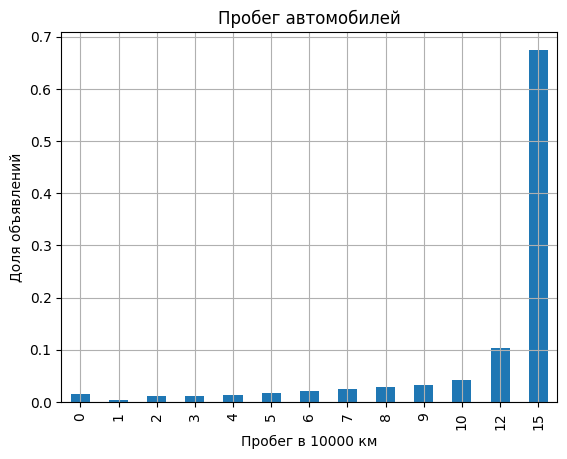

In [18]:
# Оценим, как распределяются наблюдения по километражу
data['km10000'].value_counts(normalize=True).sort_index().plot.bar(title='Пробег автомобилей', xlabel='Пробег в 10000 км', ylabel='Доля объявлений', rot=90, grid=True);

Гипотеза подтвердилась. 67 % наблюдений равны максимальному значению. При подготовке модели можно заменить этот столбец на качественный показатель больше или меньше 150 000. Впрочем, как лучше, проверим позднее.

In [19]:
data['more_150000_km'] = 1
data.loc[data['km10000'] < 15, 'more_150000_km'] = 0

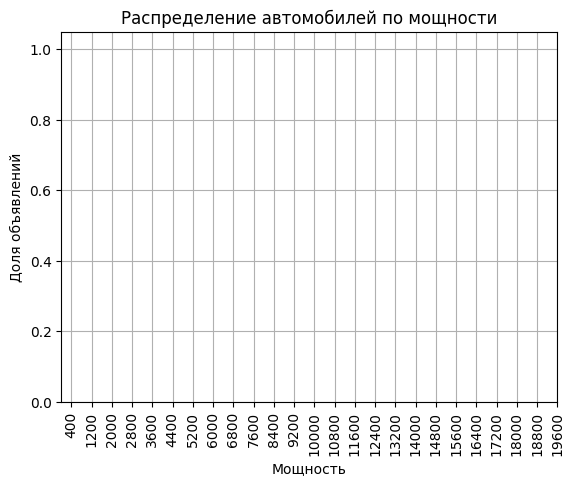

In [20]:
data['power'].value_counts(bins=25, normalize=True, sort=False).plot.bar(title='Распределение автомобилей по мощности', xlabel='Мощность', ylabel='Доля объявлений', xticks=[data['power'].min() + ((data['power'].max() - data['power'].min()) / 50) * i for i in range(1, 50, 2)], grid=True);

Все значения больше 1000 выглядят сомнительно. Диапазон до 800 необходимо рассмотреть пристальнее.

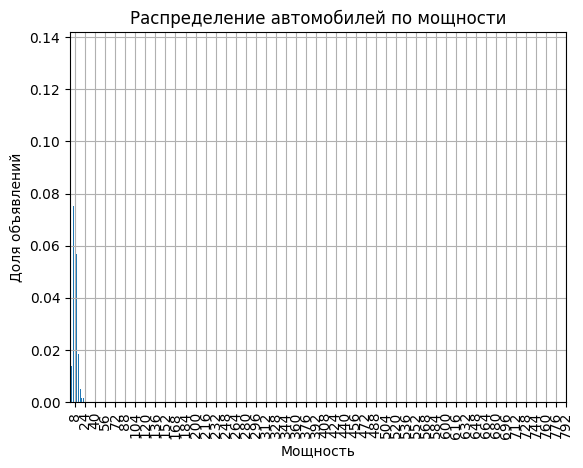

In [21]:
data.loc[data['power'] <= 800, 'power'].value_counts(bins=50, normalize=True, sort=False).plot.bar(title='Распределение автомобилей по мощности', xlabel='Мощность', ylabel='Доля объявлений', xticks=[data['power'].min() + ((800 - data['power'].min()) / 100) * i for i in range(1, 100, 2)], grid=True);

In [22]:
data.loc[data['power'] == 0, 'power'].count()

36043

Мы обнаружили, что в районе нуля у нас аномально много значений. Можно предположить, что это получается тогда, когда пользователи не заполнили значение должным образом. Заменим нули и близкие к нулю значения на nan, а затем обработаем их как пропуски. Аналогично поступим и со значениями больше 1000.

In [23]:
data.loc[data['power'] <= 16, 'power'] = np.nan
data.loc[data['power'] > 1000, 'power'] = np.nan
print(data['power'].isna().sum())
print(len(data['power'].unique()))
data = fill_by_patern(data, 'power', ['brand', 'model'])
print(data['power'].isna().sum())
print(len(data['power'].unique()))

36488
471
6
471


In [24]:
data = data.dropna()

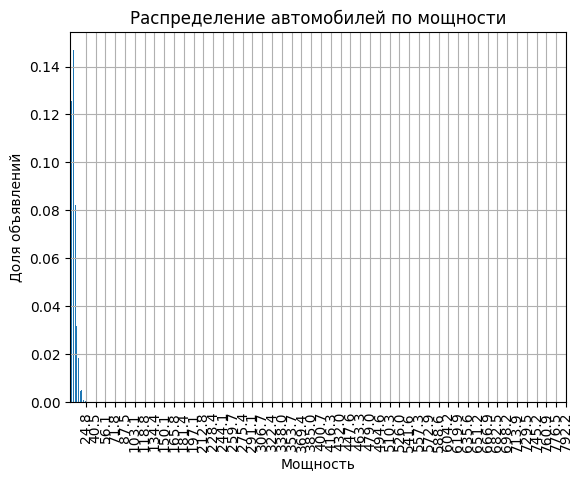

In [25]:
data.loc[data['power'] <= 800, 'power'].value_counts(bins=50, normalize=True, sort=False).plot.bar(title='Распределение автомобилей по мощности', xlabel='Мощность', ylabel='Доля объявлений', xticks=[data['power'].min() + ((800 - data['power'].min()) / 100) * i for i in range(1, 100, 2)], grid=True);

Получилось. Похоже, не заполняли данными в основном те, у кого мощность была низкой. Стеснялись?

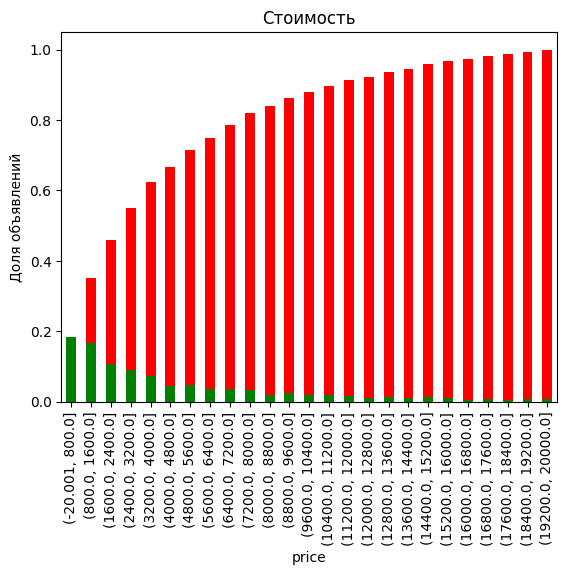

In [26]:
data['price'].value_counts(bins=25, normalize=True, sort=False).cumsum().plot.bar(title='Стоимость', xlabel='Цена', ylabel='Доля объявлений', xticks=[data['price'].min() + ((data['price'].max() - data['price'].min()) / 50) * i for i in range(1, 50, 2)], grid=True, color='r')
data['price'].value_counts(bins=25, normalize=True, sort=False).plot.bar(color='g');

Столбец с  ценой, как и в предыдущем случае, необходимо рассмотреть на меньшем диапазоне

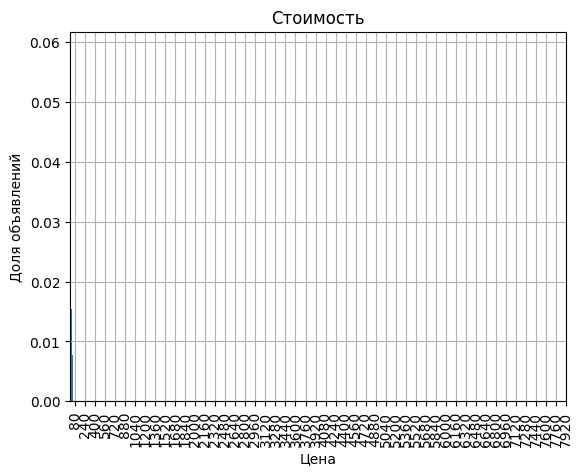

In [27]:
data.loc[data['price'] <= 8000, 'price'].value_counts(bins=50, normalize=True, sort=False).plot.bar(title='Стоимость', xlabel='Цена', ylabel='Доля объявлений', xticks=[data['price'].min() + ((8000 - data['price'].min()) / 100) * i for i in range(1, 100, 2)], grid=True);

In [28]:
data.loc[data['price'] <= 500, 'price'].value_counts().head(10)

price
0      9390
500    5469
300    2599
350    2417
400    2319
250    2096
450    1960
200    1901
150    1536
1      1020
Name: count, dtype: int64

Мы можем видеть достаточно большое число наблюдений, у которых стоимость равна или близка нулю. Это требовало бы пояснения экспертов. Вдруг люди действительно пытаются избавиться от автомобилей, например, чтобы не платить налоги. Или это такой автохлам, что люди выставляют объявления, чтобы просто у них забрали то, что они не могут довести до свалки. Проверить эти и любые другие гипотезы мы не можем. Взглянем на наиболее дешевые предложения с точки зрения года регистрации автомобилей.

In [29]:
data.loc[data['price'] <= 5, 'registration_year'].value_counts().head(10)

registration_year
2000    1150
1999     812
1998     779
1997     726
1995     635
2016     586
2001     527
2005     521
1996     506
2017     459
Name: count, dtype: int64

Мы видим, что в основном, автомобили с наиболее низкой стоимостью действительно очень старые. Но не все. Так как в остаются сомнения в достоверности подобных наблюдений, придется их удалить. К счастью, их не так много.

In [30]:
data = data.drop(data[data['price'] < 10].index)

У нас осталось еще несколько столбцов, которые мы ранее не рассматривали. Первые из них – год и месяц регистрации. Посмотрим, насколько правдоподобные данные там встречаются и объединим их.

In [31]:
data['registration_year'].describe(percentiles=[0.001, 0.25, 0.5, 0.75, 0.999])

count    334729.000000
mean       2003.804735
std          64.333321
min        1000.000000
0.1%       1963.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
99.9%      2018.000000
max        9999.000000
Name: registration_year, dtype: float64

Мы можем видеть, что у нас есть небольшой объем странных, явно неверных значений. Чтобы избавиться от них, удалим все наблюдения с годом регистрации меньше 1960 и больше 2022. Таких явно будет немного.

In [32]:
data = data.drop(data[data['registration_year'] < 1960].index)
data = data.drop(data[data['registration_year'] > 2022].index)

In [33]:
data['registration_month'].value_counts().sort_index()

registration_month
0     29479
1     22077
2     20461
3     33278
4     28194
5     28002
6     30220
7     26015
8     21726
9     22992
10    25238
11    23427
12    23366
Name: count, dtype: int64

Что же, есть нулевые значения. Скорее всего, пользователь просто не заполнил. Для того показателя, который мы будем использовать, это не так важно, поэтому исправлять не будем. Объединим год и месяц регистрации в единый показатель.

In [34]:
data['registration_year'] = (data['registration_year'] * 12 + data['registration_month']) / 12
data = data.drop('registration_month', axis=1)

У нас целых три столбца с датами. Логично предположить, что дата скачивания анкеты особой роли в ценообразовании не играет. Позднее мы ее удалим. Но сначала проверим, есть ли у нас строки, в которых анкета скачена раньше, чем размещена.

In [35]:
(data['date_crawled'] < data['date_created']).sum()

0

К счастью, таких не нашлось. Теперь посмотрим, есть ли анкеты, созданные раньше, чем была зарегистрирована машина. Это было бы тоже странно.

In [36]:
(data['date_created'].dt.year < data['registration_year'].astype('int')).sum()

12197

А вот такие есть. Удалим их как скомпрометированные, а заодно и больше ненужную дату скачивания.

In [37]:
data = data.drop(data.loc[(data['date_created'].dt.year < data['registration_year'].astype('int'))].index)
data = data.drop('date_crawled', axis=1)

Теперь сконструируем новый признак. Предположим, что дата последней активности пользователя примерно совпадает с датой продажи автомобиля. В таком случае разность между этим показателем и датой создания объявления показывает время экспозиции. Оно может оказаться важным признаком.

In [38]:
data['day_exp'] = (data['last_seen'] - data['date_created']).dt.days
data['last_seen'] = data['last_seen'].dt.year

После создания нового признака, дата создания объявления видится излишней. По этой причине удалим ее. Далее перейдем к рассмотрению почтовых индексов.

In [39]:
data = data.drop('date_created', axis=1)

In [40]:
len(data['postal_code'].unique())

8125

In [41]:
data['postal_code'].apply(lambda x: len(str(x))).value_counts()

postal_code
5    306417
4     15861
Name: count, dtype: int64

Мы видим, что почтовый индекс представляет собой четырех или пятизначное число. По нему можно определить место продажи автомобиля, а в разных регионах стоимость подержанных машин может отличаться. При этом признак этот является категориальным. 
Создавать больше восьми тысяч категорий кажется неправильным. Индексы в большинстве стран имеют четкую структуру. Например, в США по первым двум цифрам можно определить штат. В России первые три цифры практически однозначно указывают на регион почтового отделения. Попробуем выделить первые две цифры в качестве номера региона. Также у нас есть некоторое количество индексов с четырьмя числами. Пока, на всякий случай, эту информацию также сохраним в таблице, вдруг это признак, а не ошибка.


In [42]:
data['postal_code_start'] = data['postal_code'].apply(lambda x: str(x)[:2])

In [43]:
data['postal_code_len'] = data['postal_code'].apply(lambda x: len(str(x)) - 4)

Наконец мы получили DataFrame с очищенными данными. Остается только проверить его на наличие явных дубликатов.

In [44]:
print(data.shape[0])
data.drop_duplicates(inplace=True)
data.shape[0]

322278


311569

### Выводы
На этом мы завершаем первый раздел. Здесь было проведено множество действий по очистке данных от пропусков и аномалий. Нам удалось:
- загрузить данные;
- заполнить существенную часть текстовых столбцов, опираясь на наблюдения в таблице, не имеющие пропусков;
- обработать аномалии в числовых столбцах;
- удалить сомнительные по качеству наблюдения и бесполезные столбцы;
У нас теперь есть DataFrame без пропусков. Наверняка некоторые из признаков будут излишними. Уже сейчас понятно, что некоторые из них дублируют друг друга. С тем, какие оставлять, мы разберемся позднее. Также, будет необходимо разделить выборки и применить кодирование.


## Обучение моделей

Этот раздел будет посвящен обучению и выбору моделей. Но прежде чем этим заняться, необходимо произвести ряд подготовительных операций. Начнем с того, что выделим целевой показатель из DataFrame, а также отложим тестовую выборку.

In [45]:
target = data['price']
features = data.drop('price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=23)

Прежде чем создавать модели, попробуем разобраться, какие из множества признаков полезны, а какие – нет. Также попробуем сравнить эффективность логичного в нашей ситуации onehotencoder и ordinalencoder, применение которого, скорее всего, потребует гораздо меньше ресурсов.
Начнем с создания двух вариантов трансформаторов. Первый будет применять к категориальным признакам OHE, а второй – порядковое кодирование.


In [46]:
# Создадим преобразователь с OHE
ct_ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), 
      make_column_selector(dtype_include=object))],
    remainder='passthrough')

# Создадим преобразователь с ordinal encoder
ct_ord = ColumnTransformer(
    [('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
      make_column_selector(dtype_include=object))],
    remainder='passthrough')

Попробуем Обучить небольшой случайный лес, чтобы оценить, на какие признаки он опирается. Сначала используем ряд признаков, подходящих для OHE. Также, для экономии ресурсов, будем использовать только часть выборки. А чтобы было, с чем сравнить значимость, добавим столбец с явно бесполезными данными.

In [47]:
features_train['random'] = np.random.random(features_train.shape[0])

In [48]:
%%time
columns_for_ohe = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'last_seen', 'km10000', 'more_150000_km', 'day_exp', 'postal_code_start', 'postal_code_len', 'random']
model = Pipeline(
    [('ct', ct_ohe),
     ('rf', RandomForestRegressor(n_estimators=10))]
    )
model.fit(features_train[columns_for_ohe].iloc[:25000, :], target_train.iloc[:25000]);

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: total: 17.5 s
Wall time: 17.8 s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000200C74DB1F0>)])),
                ('rf', RandomForestRegressor(n_estimators=10))])

Лес обучили, посмотрим, какие признаки стали для него важными.  Некоторые категориальные признаки разбились на десятки отдельных. Для них будем считать сумму значимостей. Также, какова точность модели на 10 000 образцов.

In [49]:
%%time
def unite_category(series, category):
    '''суммирует значения похожих индексов'''
    for cat in category:
        ind = [i for i in series.index if cat in i]
        series = pd.concat([series, pd.Series({cat: sum(series.loc[ind])})])
        series = series.drop(ind)
    return series

category_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'postal_code_start']
importance = pd.Series(model['rf'].feature_importances_,
    index=model['rf'].feature_names_in_)
importance = unite_category(importance, category_features)
print('Значимость признаков')
display(importance.sort_values(ascending=False))
prediction = model.predict(features_train[columns_for_ohe].iloc[25001:35000, :])
print('Точность модели',
    mean_squared_error(prediction, target_train.iloc[25001:35000], squared=False))


Значимость признаков


remainder__registration_year    0.531878
remainder__power                0.238151
model                           0.042651
postal_code_start               0.038055
remainder__km10000              0.028248
brand                           0.027532
vehicle_type                    0.021099
remainder__day_exp              0.020038
remainder__random               0.017233
remainder__kilometer            0.016261
remainder__repaired             0.007738
fuel_type                       0.004267
gearbox                         0.002994
remainder__more_150000_km       0.002943
remainder__postal_code_len      0.000911
remainder__last_seen            0.000000
dtype: float64

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Точность модели 1937.710809654574
CPU times: total: 406 ms
Wall time: 446 ms


Что же, попробуем удалить все признаки, значимость которых ниже случайных чисел. Также попробуем убрать бренд и тип транспортного средства. Скорее всего, эти данные уже входят в модель. Откорректируем список применяемых столбцов и запустим процесс заново.

In [50]:
%%time
columns_for_ohe = ['registration_year', 'power', 'model', 'kilometer', 'day_exp', 'postal_code_start', 'random']
model = Pipeline(
    [('ct', ct_ohe),
     ('rf', RandomForestRegressor(n_estimators=10))]
    )
model.fit(features_train[columns_for_ohe].iloc[:25000, :], target_train.iloc[:25000])

category_features = ['model', 'postal_code_start']
importance = pd.Series(model['rf'].feature_importances_,
    index=model['rf'].feature_names_in_)
importance = unite_category(importance, category_features)
print('Значимость признаков')
display(importance.sort_values(ascending=False))
prediction = model.predict(features_train[columns_for_ohe].iloc[25001:35000, :])
print('Точность модели',
    mean_squared_error(prediction, target_train.iloc[25001:35000], squared=False))

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Значимость признаков


remainder__registration_year    0.533492
remainder__power                0.244432
model                           0.074907
postal_code_start               0.051781
remainder__kilometer            0.049091
remainder__random               0.023199
remainder__day_exp              0.023097
dtype: float64

Точность модели 2079.9556907844367
CPU times: total: 14.6 s
Wall time: 14.7 s


C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Что же, мы несколько потеряли в точности и почти не ускорили модель. Соответственно, смысла удалять признаки нет. Пока на этом остановимся. Посмотрим, как себя проявит порядковая кодировка. Здесь, так как мы практически не ограничены в количестве категорий в каждом признаке, будем использовать почтовые индексы в их первоначальном виде.

In [51]:
%%time
columns_for_ord = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'postal_code', 'last_seen', 'km10000', 'more_150000_km', 'day_exp', 'postal_code_len', 'random']
model = Pipeline(
    [('ct', ct_ord),
     ('rf', RandomForestRegressor(n_estimators=10))]
    )
model.fit(features_train[columns_for_ord].iloc[:25000, :], target_train.iloc[:25000])

importance = pd.Series(model['rf'].feature_importances_,
    index=model['rf'].feature_names_in_)
print('Значимость признаков')
display(importance.sort_values(ascending=False))
prediction = model.predict(features_train[columns_for_ord].iloc[25001:35000, :])
print('Точность модели',
    mean_squared_error(prediction, target_train.iloc[25001:35000], squared=False))

Значимость признаков


remainder__registration_year    0.540471
remainder__power                0.243802
ord__brand                      0.026935
ord__model                      0.025495
remainder__postal_code          0.024513
remainder__day_exp              0.024476
remainder__kilometer            0.023882
remainder__random               0.023367
ord__vehicle_type               0.021828
remainder__km10000              0.020731
remainder__repaired             0.008735
ord__fuel_type                  0.006194
ord__gearbox                    0.004655
remainder__more_150000_km       0.004447
remainder__postal_code_len      0.000470
remainder__last_seen            0.000000
dtype: float64

Точность модели 1979.4520064016617
CPU times: total: 3.8 s
Wall time: 3.84 s


В результате точность модели упала совсем немного, но скорость работы возрасла в три раза. Похоже, ordinal encoder лучше подходит для наших данных, по крайней мере в сочетании со случайным лесом.
Заметим, что из всех признаков, связанных с километражом бесполезным оказался признак more_150000_km. Два других близки по смыслу, поэтому оставим только первоначальный. Также last_seen не пригодился моделям. Их, а также случайный признак удалим.


In [52]:
# Удаляем лишние столбцы
for df in [features_train, features_test]:
    df = df.drop(['more_150000_km', 'last_seen', 'km10000'], axis=1)
features_train = features_train.drop('random', axis=1)

Прежде чем перейти к построению моделей создадим функцию качества, которую будем применять при кросс-валидации

In [53]:
# Создадим функцию для оценки rmse
rmse = make_scorer(lambda x, y: mean_squared_error(x, y, squared=False), greater_is_better=False)

Далее на тренировочной выборке оценим точность базовой модели, которая все время выдает одинаковый ответ.Далее на тренировочной выборке оценим точность базовой модели, которая все время выдает одинаковый ответ.

In [54]:
model = DummyRegressor()
model.fit(features_train, target_train)
print('Точность базовой модели', mean_squared_error(target_train, model.predict(features_train), squared=False))

Точность базовой модели 4536.343190167019


Теперь можем переходить к построению моделей и подбору гиперпараметров моделей. А начнем мы со случайного леса в сочетании с one hot encoder.

In [55]:
%%time
columns_for_ohe = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'day_exp', 'postal_code_start', 'postal_code_len']
model = Pipeline(
    [('ct', ct_ohe),
    ('rf', RandomForestRegressor())]
    )
param = {'rf__max_depth': [10, 50, 250],
    'rf__n_estimators': [10, 50, 250]}

grid_forest = GridSearchCV(model, param_grid=param, cv=3, n_jobs=-1, scoring=rmse)
grid_forest.fit(features_train[columns_for_ohe], target_train)
print('Результаты подбора гиперпараметров для RandomForestRegression')
pd.DataFrame(grid_forest.cv_results_).sort_values(by='rank_test_score')

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Результаты подбора гиперпараметров для RandomForestRegression
CPU times: total: 1h 6min 29s
Wall time: 2h 54min 56s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,4468.355163,225.194094,47.161152,3.850409,50,250,"{'rf__max_depth': 50, 'rf__n_estimators': 250}",-1574.590358,-1591.542387,-1600.817674,-1588.983473,10.859069,1
8,3440.200302,117.179246,38.200099,5.712093,250,250,"{'rf__max_depth': 250, 'rf__n_estimators': 250}",-1575.418811,-1590.809760,-1600.806257,-1589.011609,10.442082,2
7,1107.580073,60.407234,17.043205,4.615123,250,50,"{'rf__max_depth': 250, 'rf__n_estimators': 50}",-1588.010478,-1602.332552,-1611.202075,-1600.515035,9.554757,3
4,1156.460939,1.810706,12.131521,0.365466,50,50,"{'rf__max_depth': 50, 'rf__n_estimators': 50}",-1586.199053,-1600.904886,-1616.818296,-1601.307412,12.503494,4
3,248.289868,2.351554,4.446158,0.036593,50,10,"{'rf__max_depth': 50, 'rf__n_estimators': 10}",-1637.056060,-1658.634763,-1668.129442,-1654.606755,13.001472,5
6,235.874877,0.736646,3.937883,0.242202,250,10,"{'rf__max_depth': 250, 'rf__n_estimators': 10}",-1640.216959,-1658.810863,-1666.131009,-1655.052943,10.907978,6
2,2675.719197,18.299366,9.674708,0.868821,10,250,"{'rf__max_depth': 10, 'rf__n_estimators': 250}",-1867.885403,-1881.353591,-1892.954989,-1880.731328,10.244070,7
1,589.550126,3.852094,4.561825,0.713507,10,50,"{'rf__max_depth': 10, 'rf__n_estimators': 50}",-1871.990714,-1881.592119,-1891.487004,-1881.689946,7.959628,8
0,151.714994,0.984733,2.646694,0.067090,10,10,"{'rf__max_depth': 10, 'rf__n_estimators': 10}",-1884.609033,-1896.224230,-1908.263770,-1896.365677,9.657524,9


Лучшей оказалась модель с глубиной 50 и 250 оценщиками. Ее и будем сравнивать с другими моделями. Ее основной недостаток – низкая скорость обучения и предсказания. Фактически, если случайный лес окажется наиболее точной моделью, может понадобиться перейти к более простой, более быстрой, но менее точной модели. Как мы можем видеть, снижение числа оценщиков в 5 раз повышает скорость примерно в 4 раза при небольшой падении качества.
Далее попробуем случайный лес с ordinal encoder.


In [56]:
%%time
columns_for_ord = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'postal_code', 'day_exp']
model = Pipeline(
    [('ct', ct_ord),
    ('rf', RandomForestRegressor())]
    )
param = {'rf__max_depth': [10, 50, 250],
    'rf__n_estimators': [10, 50, 250]}

grid_forest = GridSearchCV(model, param_grid=param, cv=3, n_jobs=-1, scoring=rmse)
grid_forest.fit(features_train[columns_for_ord], target_train)
print('Результаты подбора гиперпараметров для RandomForestRegression с ordinal encoder')
pd.DataFrame(grid_forest.cv_results_).sort_values(by='rank_test_score')

Результаты подбора гиперпараметров для RandomForestRegression с ordinal encoder
CPU times: total: 9min 29s
Wall time: 24min 33s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,523.018461,3.879847,30.374732,2.417048,250,250,"{'rf__max_depth': 250, 'rf__n_estimators': 250}",-1603.826500,-1618.698235,-1612.695082,-1611.739939,6.108810,1
5,551.385626,19.960416,33.635393,7.217055,50,250,"{'rf__max_depth': 50, 'rf__n_estimators': 250}",-1605.159218,-1617.297844,-1612.903777,-1611.786946,5.018103,2
7,119.769248,2.408777,4.821321,0.683359,250,50,"{'rf__max_depth': 250, 'rf__n_estimators': 50}",-1619.337048,-1632.978235,-1625.575559,-1625.963614,5.575747,3
4,123.126152,16.545564,4.170962,0.422439,50,50,"{'rf__max_depth': 50, 'rf__n_estimators': 50}",-1622.811829,-1631.602983,-1627.231795,-1627.215535,3.588992,4
6,27.830830,0.428513,1.124926,0.019984,250,10,"{'rf__max_depth': 250, 'rf__n_estimators': 10}",-1681.412749,-1698.772954,-1698.536126,-1692.907276,8.128433,5
3,22.148763,1.904094,1.145196,0.016496,50,10,"{'rf__max_depth': 50, 'rf__n_estimators': 10}",-1691.431908,-1704.506849,-1698.374842,-1698.104533,5.341243,6
2,245.877191,23.134150,4.516642,0.271222,10,250,"{'rf__max_depth': 10, 'rf__n_estimators': 250}",-1861.091476,-1870.013794,-1874.149214,-1868.418162,5.448894,7
1,50.749513,0.600853,1.122116,0.237046,10,50,"{'rf__max_depth': 10, 'rf__n_estimators': 50}",-1864.807913,-1873.376726,-1874.414710,-1870.866450,4.304939,8
0,10.793540,0.017622,0.338855,0.020064,10,10,"{'rf__max_depth': 10, 'rf__n_estimators': 10}",-1884.675269,-1883.892888,-1896.184903,-1888.251020,5.619188,9


Логика работы ordinal encoder в данном случае непонятна, но он неплохо справляется с задачей. В целом, это альтернатива предыдущей модели. Точность немного ниже, а скорость гораздо выше. Переходим к варианту линейной регрессии. Здесь из-за большого объема применяется SGD. Но прежде обновим преобразователь данных, так как здесь полезным будет масштабирование числовых данных.

In [57]:
# обновим преобразователь столбцов, добавив масштабирование
ct_ohe_and_scaler  = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), 
      make_column_selector(dtype_include=object)),
    ('numbers', StandardScaler(), 
     make_column_selector(dtype_include=np.number))],
    remainder='passthrough')

Лучшей оказалась модель с глубиной 24 и 60 оценщиками. Ее и будем сравнивать с другими моделями. Далее у нас на очереди линейная регрессия с регуляризацией.
(На самом деле пробовал до 160 оценщиков. В два раза дольше обучается ради выигрыша в точности в пару долларов. Оставил только один этап подбора параметров).




In [58]:
%%time
columns_for_ohe = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'day_exp', 'postal_code_start', 'postal_code_len']
model = Pipeline(
    [('ct', ct_ohe_and_scaler),
    ('SGD', SGDRegressor(early_stopping=True))]
    )
param = {'SGD__alpha': [0, 0.1, 1, 2, 5]}

grid_line = GridSearchCV(model, param_grid=param, cv=3, n_jobs=-1, scoring=rmse)
grid_line.fit(features_train[columns_for_ohe], target_train)
print('Результаты подбора гиперпараметров для SGDRegressor')
pd.DataFrame(grid_line.cv_results_).sort_values(by='rank_test_score')

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Результаты подбора гиперпараметров для SGDRegressor
CPU times: total: 20.4 s
Wall time: 1min 49s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SGD__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,67.518379,2.660707,3.758517,1.455544,0,{'SGD__alpha': 0},-2673.732053,-2668.307920,-2680.567655,-2674.202543,5.016061,1
1,66.455437,1.664422,2.977019,1.121304,0.1,{'SGD__alpha': 0.1},-2876.340951,-2871.695475,-2889.527148,-2879.187858,7.552960,2
2,35.465027,18.847750,2.519759,1.119148,1,{'SGD__alpha': 1},-3339.265536,-3315.884842,-3343.120903,-3332.757093,12.033858,3
3,13.155859,1.249641,1.745923,0.733990,2,{'SGD__alpha': 2},-3610.984751,-3597.538722,-3604.892129,-3604.471868,5.497356,4
4,9.161082,1.433034,1.648387,0.338874,5,{'SGD__alpha': 5},-4063.205175,-4010.250978,-4039.454533,-4037.636895,21.656633,5


Результат настолько плох, что настраивать эту модель дальше бессмысленно. Перейдем к градиентному бустингу.

In [59]:
%%time
columns_for_ohe = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'day_exp', 'postal_code_start', 'postal_code_len']
LGBM_model = Pipeline(
    [('ct', ct_ohe),
    ('lgbm', LGBMRegressor())]
)
param = {'lgbm__n_estimators': [100, 300, 900],
    'lgbm__num_leaves': [60, 120, 240]}
grid_light = GridSearchCV(LGBM_model, param_grid=param, cv=5, n_jobs=-1, scoring=rmse)
grid_light.fit(features_train[columns_for_ohe], target_train)
pd.DataFrame(grid_light.cv_results_).sort_values(by='rank_test_score')

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: total: 1min 20s
Wall time: 7min 12s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__n_estimators,param_lgbm__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,58.297871,2.958383,46.491304,4.812517,900,120,"{'lgbm__n_estimators': 900, 'lgbm__num_leaves'...",-1528.047612,-1512.157247,-1499.785796,-1541.733284,-1532.588170,-1522.862422,14.998115,1
5,41.754353,5.649014,13.795370,1.549757,300,240,"{'lgbm__n_estimators': 300, 'lgbm__num_leaves'...",-1528.122084,-1511.693031,-1500.577211,-1544.040624,-1540.250915,-1524.936773,16.603682,2
8,77.833248,6.728329,44.791223,10.143343,900,240,"{'lgbm__n_estimators': 900, 'lgbm__num_leaves'...",-1528.170816,-1516.295892,-1500.932679,-1540.946798,-1538.999579,-1525.069153,14.935301,3
6,45.342432,1.578731,27.062158,1.093150,900,60,"{'lgbm__n_estimators': 900, 'lgbm__num_leaves'...",-1534.585869,-1518.376486,-1514.697717,-1555.862278,-1540.255346,-1532.755539,15.009069,4
4,39.261529,3.286780,8.275248,1.645723,300,120,"{'lgbm__n_estimators': 300, 'lgbm__num_leaves'...",-1539.281958,-1523.336684,-1515.203550,-1560.154567,-1544.371353,-1536.469622,15.849562,5
2,34.496116,6.502200,6.403213,1.027697,100,240,"{'lgbm__n_estimators': 100, 'lgbm__num_leaves'...",-1547.935640,-1533.278947,-1523.638907,-1571.990941,-1560.563761,-1547.481639,17.562723,6
3,35.355916,2.456364,8.061569,1.749929,300,60,"{'lgbm__n_estimators': 300, 'lgbm__num_leaves'...",-1560.546379,-1543.126437,-1541.666197,-1586.298334,-1564.415713,-1559.210612,16.304166,7
1,40.997020,15.932791,6.121548,1.150014,100,120,"{'lgbm__n_estimators': 100, 'lgbm__num_leaves'...",-1576.900057,-1558.464425,-1552.528689,-1600.596933,-1579.443222,-1573.586665,17.011484,8
0,59.888719,5.983106,5.901708,0.903745,100,60,"{'lgbm__n_estimators': 100, 'lgbm__num_leaves'...",-1612.607887,-1596.567975,-1591.917435,-1643.182120,-1613.254011,-1611.505886,17.969434,9


Первые результаты уже превзошли другие модели. Очевидно, имеет смысл попробовать другие значения гиперпараметров вокруг наилучшего из обнаруженных вариантов.

In [60]:
param = {'lgbm__n_estimators': [500, 900, 1500],
    'lgbm__num_leaves': [120, ]}
grid_light = GridSearchCV(LGBM_model, param_grid=param, cv=5, n_jobs=-1, scoring=rmse)
grid_light.fit(features_train[columns_for_ohe], target_train)
pd.DataFrame(grid_light.cv_results_).sort_values(by='rank_test_score')

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__n_estimators,param_lgbm__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,79.555300,15.452393,51.035735,4.369565,900,120,"{'lgbm__n_estimators': 900, 'lgbm__num_leaves'...",-1528.047612,-1512.157247,-1499.785796,-1541.733284,-1532.588170,-1522.862422,14.998115,1
2,82.189081,9.675306,46.020604,6.528469,1500,120,"{'lgbm__n_estimators': 1500, 'lgbm__num_leaves...",-1529.333194,-1515.628788,-1500.464857,-1541.817873,-1533.308296,-1524.110602,14.536044,2
0,70.364759,9.564316,20.512998,3.525044,500,120,"{'lgbm__n_estimators': 500, 'lgbm__num_leaves'...",-1531.364902,-1514.847552,-1506.548342,-1549.170570,-1536.614088,-1527.709091,15.273870,3


Остановим свой выбор на модели с 900 деревьями и 120 листьями. Она лучше других предсказывает стоимость. Скорость обучения и предсказания также лучше.

### Выводы
В этой части проекта мы завершили подготовку данных для обучения моделей и проверили 4 модели.
- Сначала мы разделили выборку на тренировочную и тестовую, а также подготовили функцию потерь.
- Далее с помощью случайного леса выяснили, насколько полезны сконструированные на прошлом этапе признаки. В результате уменьшили их количество почти на четверть.
- Потом оценили эффективность случайного леса с двумя вариантами кодирования категориальных признаков, стахастического градиентного спуска и бустинга.
Градиентный спуск показал себя быстрой, но неточной моделью. Случайный лес достаточно точный, но очень медленный. Бустинг смог собрать преимущества обеих моделей – самая точная и самая быстрая. Проверять на тестовой выборке будем именно ее.


## Тестирование лучшей модели

Осталось проверить лучшую из моделей на тестовой выборке. Для этого заново обучим ее на полной тренировочной выборке, а затем спрогнозируем стоимость для тестовой выборки.


In [61]:
%%time
model = grid_light.best_estimator_
model.fit(features_train[columns_for_ohe], target_train)

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU times: total: 1min
Wall time: 11.9 s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000200C4B74940>)])),
                ('lgbm', LGBMRegressor(n_estimators=900, num_leaves=120))])

In [62]:
%%time
prediction_test = model.predict(features_test[columns_for_ohe])
print('RMSE на тестовой выборке', mean_squared_error(target_test, prediction_test, squared=False))

RMSE на тестовой выборке 1501.3300909051013
CPU times: total: 12.5 s
Wall time: 2.81 s


Проверка модели оказалась успешной. Она практически мгновенно обучается и демонстрирует результаты даже лучшие, чем при кросс-валидации. Результат следует признать хорошим.

## Выводы
Перед нами стояла задача подобрать наиболее точную и быструю модель для прогнозирования стоимости подержанных автомобилей. В предоставленных данных были пропущенные данные и аномальные показатели. Эта информация могла бы оказаться полезной для создателей сервиса, ведь она может указывать на ошибки и недоработки в системе. Нам же пришлось дополнять и отсеивать подобные записи. Кроме решения этой задачи на первом этапе мы сконструировали ряд дополнительных признаков на основе имеющихся.
На втором этапе был создан показатель качества модели, соответствующий пожеланиям заказчика. Далее мы отсеяли около 25 % признаков как не имеющие ценности для моделей путем сравнения их значения с совершенно случайным числом. Далее были подобраны наилучшие гиперпараметры для четырех моделей. К счастью, в нашем случае не пришлось искать компромисс между скоростью и точностью. По обоим параметрам победила модель lightgbm.LGBMRegressor. Она показал лучшую скорость обучения, предсказания и точность.
На третьем этапе мы проверили модель на тестовой выборке. Она подтвердила свои характеристики, а значит может быть рекомендована заказчику.

